In [2]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Grandata") \
    .getOrCreate()


In [ ]:
# Define the path to the source folder
source_folder_path = "source"

# Read CSV files from the source folder
df_events = spark.read.csv(f"{source_folder_path}/events.csv.gz", header=True, inferSchema=True)

# Show the DataFrame
df_events.show()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as _sum, md5, concat_ws, hour
import matplotlib.pyplot as plt

import os
import sys

# Set the HADOOP_HOME environment variable to the directory containing winutils.exe
# os.environ['HADOOP_HOME'] = "C:\\Hadoop"

# Add the Hadoop bin directory to the PATH environment variable
# os.environ['PATH'] += os.pathsep + os.path.join(os.environ['HADOOP_HOME'], 'bin')

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYTHONPATH'] = sys.executable

print(os.environ['PYSPARK_PYTHON'])
print(os.environ['PYSPARK_DRIVER_PYTHON'])
print(os.environ['PYTHONPATH'])

c:\Users\mbunader\AppData\Local\Programs\Python\Python312\python.exe
c:\Users\mbunader\AppData\Local\Programs\Python\Python312\python.exe
c:\Users\mbunader\AppData\Local\Programs\Python\Python312\python.exe


In [4]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

df_free_destinations = spark.read.csv(f"{source_folder_path}/free_sms_destinations.csv.gz", header=True, inferSchema=True)

# free_destinations = df_free_destinations.select("id").rdd.flatMap(lambda x: x).collect()

# Collect free destination numbers into a list without using RDD
free_destinations = [row['id'] for row in df_free_destinations.select("id").collect()]

print(free_destinations)

['374', 'D52', '861', '5B0', '4CA', '465', '048', 'D5B', 'FD6', '2D3', 'B3F', '6AF', '216', 'C3A', 'EE2', '328', '99E', 'BF6', '60F', '6AC', '557', '598', '4D2', '1A5', '539', '40A', 'C74', 'C38', 'CA3', 'ECE', '3DC', '48C', '55C', '839', '555', 'F31', '99A', '7D2', '667', 'CF4', '1EB', 'B6B', '825', 'CB4', '7E2', '227', '2BF', '8D1', '3A2', '1A0', '3B1', '758', 'F41', '1CF', 'B65', '92E', '585', '9D8', '835', '1D7', '7D4', 'C2F', 'BF8', '263', '3CA', '795', '313', '7BB', 'A6B', '6FE', '218', 'D85', 'F40', '840', '6BE', 'F84', '044', 'C19', 'E85', 'CA9', '04C', '18A', '6C9', '57A', '416', '93A', '704', '099', '670', '00D', 'C2E', '1C4', 'B57', 'B7F', '2B8', '9B4', '6D3', '5E7', '2F5', 'DAF', '4E0', '6CE', 'E25', 'E9F', '5E1', '3EB', '426', '44E', 'CAE', 'DAA', 'E0E', 'D25', '8F5', '688', '5BC', '0C4', '34D', '017', 'BB4', '5CB', '12D', '2D0', '7F6', '9CD', '314', '46A', '30D', '57E', '2E3', '1C9', '874', '229', '5BA', '533', '573', '348', '3B5', 'E18', '9AD', '1DA', '6EC', '21E', 'CB7'

In [5]:
# Read CSV files from the source folder
df_events = spark.read.csv(f"{source_folder_path}/events.csv.gz", header=True, inferSchema=True)
df_free_destinations = spark.read.csv(f"{source_folder_path}/free_sms_destinations.csv.gz", header=True, inferSchema=True)

# Collect free destination numbers into a list
# free_destinations = df_free_destinations.select("id").rdd.flatMap(lambda x: x).collect()

free_destinations = [row['id'] for row in df_free_destinations.select("id").collect()]

# Calculate the billing amount for each SMS
df_billing = df_events.withColumn(
    "billing_amount",
    when(col("id_destination").isin(free_destinations), 0.0)
    .when(col("region").between(1, 5), 1.5)
    .when(col("region").between(6, 9), 2.0)
    .otherwise(0.0)
)

# Calculate the total amount billed by the service provider
total_billing = df_billing.agg(_sum("billing_amount").alias("total_billing")).collect()[0]["total_billing"]
print(f"Total amount billed by the service provider: ${total_billing}")



Total amount billed by the service provider: $1696075.0


In [6]:
# import os

# Set the HADOOP_HOME environment variable to the directory containing winutils.exe
# os.environ['HADOOP_HOME'] = "C:\\Hadoop\\bin\\"


# Verify the environment variables
# print(os.environ['HADOOP_HOME'])

# Generate a dataset with the top 100 users with the highest billing
df_top_users = df_billing.groupBy("id_source") \
    .agg(_sum("billing_amount").alias("total_billing")) \
    .orderBy(col("total_billing").desc()) \
    .limit(100) \
    .withColumn("hashed_id", md5(col("id_source").cast("string")))

# Write the dataset in Parquet format with gzip compression
df_top_users.write.parquet("top_users_billing.parquet", mode="overwrite", compression="gzip")

df_top_users.show()

+---------+-------------+--------------------+
|id_source|total_billing|           hashed_id|
+---------+-------------+--------------------+
|      4D3|      18573.0|911914c7729eedbdf...|
|      76D|      13508.0|bd180b7811395cbce...|
|      07E|       4070.0|14a0660ae2f5d1868...|
|      541|       1707.0|16c222aa19898e505...|
|      B86|       1292.5|bc97b32ee2abb9c18...|
|      3AE|       1026.0|6a57072949dbc409c...|
|      1BD|       1023.5|f5a45e33602ea62f9...|
|      3E0|       1015.5|e9d076deb3451cc49...|
|      D29|        892.0|1b2e80021b5fc82bf...|
|      E6F|        714.5|159e1f3d6ff0e7c3c...|
|      D67|        702.0|4e321438558549248...|
|      871|        680.0|aeb3135b436aa5537...|
|      8F1|        652.0|496ce5f942d15eefb...|
|      383|        626.5|beed13602b9b0e6ec...|
|      BD4|        616.0|aa35b36e4d1395542...|
|      D0B|        611.5|e87c495061191f4df...|
|      756|        610.5|2823f4797102ce1a1...|
|      556|        605.5|11b921ef080f77360...|
|      7A5|  

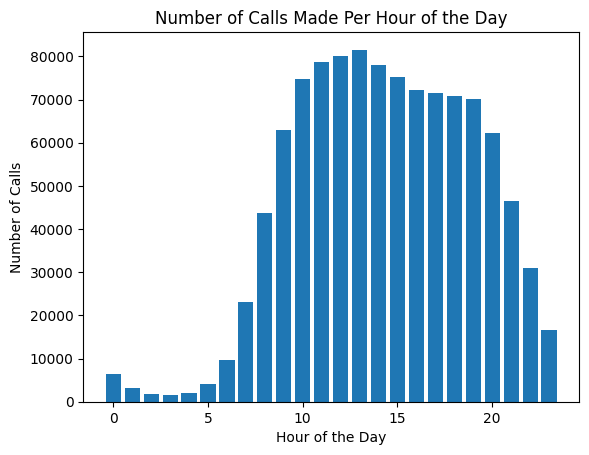

In [9]:
# Plot a histogram of the number of calls made per hour of the day
df_calls_per_hour = df_events.groupBy("hour").agg(_sum("calls").alias("total_calls")).orderBy("hour")

# Collect the data for plotting
hours = [row['hour'] for row in df_calls_per_hour.select("hour").collect()]
call_counts = [row['total_calls'] for row in df_calls_per_hour.select("total_calls").collect()]

# Plot the histogram
plt.bar(hours, call_counts)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Calls")
plt.title("Number of Calls Made Per Hour of the Day")
plt.show()

# Stop the SparkSession
spark.stop()